<a href="https://colab.research.google.com/github/lookmeebbear/BKK_BHE/blob/main/BKK_BHE_DownloadIMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Urban Building Height Estimation from Open Remote Sensing**

*Thepchai Srinoi, Phisan Santitamnont, Thirawat Bunnakulpipat*

Department of Survey Engineering

Faculty of Engineering Chulalongkorn University


**ตัวอย่าง ขั้นตอนการดาวน์โหลดภาพจาก Google Earth Engine**

(1) Download and Install Libraries

In [1]:
import cv2
import folium
import pandas as pd
from os import path as op
import pickle
import matplotlib.pyplot as plt
import numpy as np
import folium


(2) Connect to Google Earth Engine ... นำชื่อ project ใน code.earthengine.google มาใส่ใน ee.Initialize

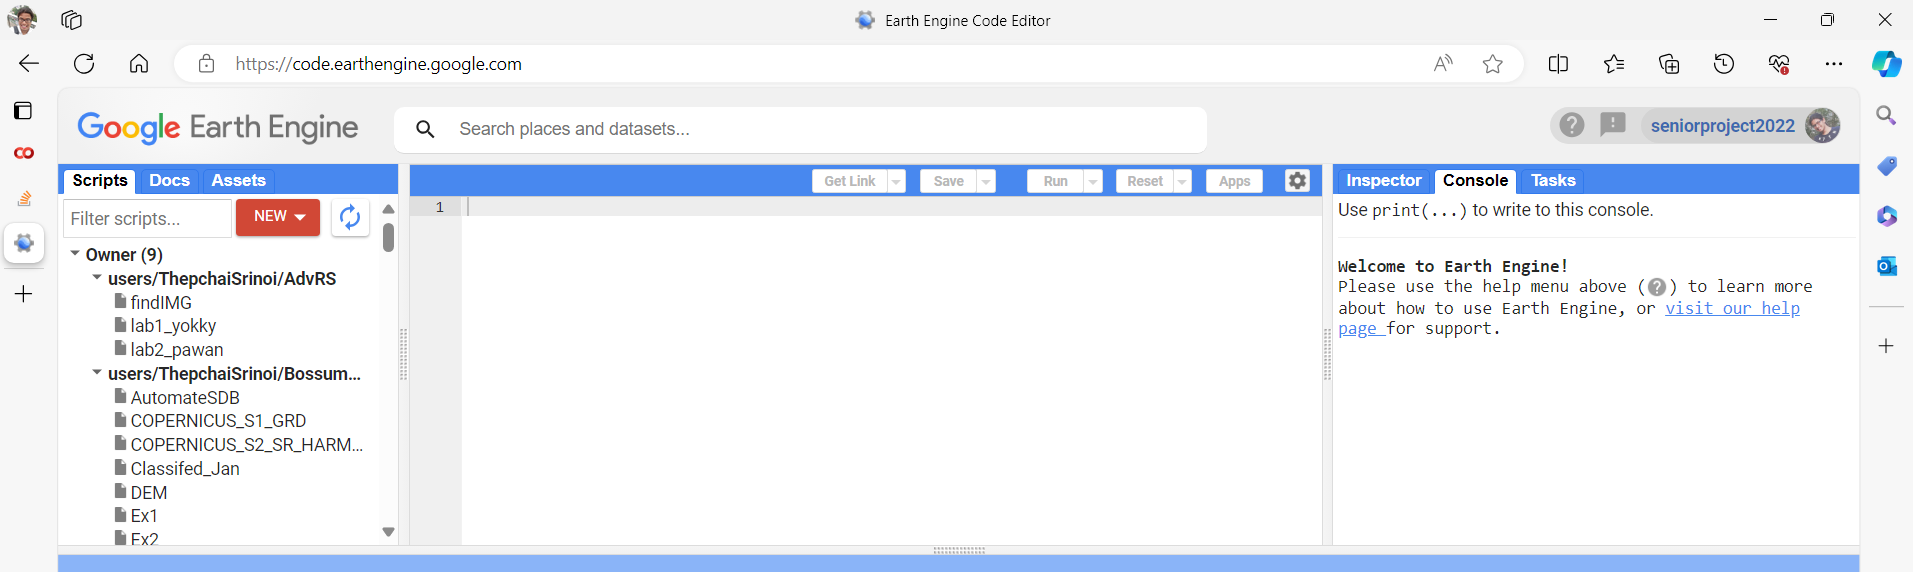

In [3]:
import ee
# Authenticate to the Earth Engine servers
ee.Authenticate()
# Initialize the API
ee.Initialize(project='seniorproject2022')

(3) เตรียมพื้นที่ทำงาน และ ฟังก์ชันแสดงแผนที่

กำหนดพื้นที่งานเรา

In [5]:
lat_min, lat_max, lon_min, lon_max = (13.493, 13.955, 100.327, 100.939)
AOI = ee.Geometry.Polygon(
        [[[lon_min, lat_max],
           [lon_min, lat_min],
           [lon_max, lat_min],
           [lon_max, lat_max]]])

ฟังก์ชันแสดงแผนที่

In [4]:
# Map Visualization : Google Earth Engine
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

(4) Overview time-series SAR satellite imagery (sentinel-1 A/B)

โหลดภาพแรกของทุกเดือน เลือกทั้ง Ascending/Descending แล้ว แยก polarization VV, VH

In [6]:
for month in range(1,13) :
  fromdate = '2022-' + str(month) +'-01'
  todate = '2022-' + str(month) +'-28'

  image = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                        .filterBounds(AOI)
                        .filterDate(ee.Date(fromdate), ee.Date(todate))
                        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                        .first().clip(AOI) )

  if month == 1 :
    VH = (image.select('VH')).rename('VH_A_'+str(month))
    VV = (image.select('VV')).rename('VV_A_'+str(month))

  else :
    VH = VH.addBands(image.select('VH').rename('VH_A_'+str(month)))
    VV = VV.addBands(image.select('VV').rename('VV_A_'+str(month)))

  image2 = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                        .filterBounds(AOI)
                        .filterDate(ee.Date(fromdate), ee.Date(todate))
                        .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
                        .first().clip(AOI) )


  VH = VH.addBands(image2.select('VH').rename('VH_D_'+str(month)))
  VV = VV.addBands(image2.select('VV').rename('VV_D_'+str(month)))

print(VV.bandNames().getInfo())
print(VH.bandNames().getInfo())

['VV_A_1', 'VV_D_1', 'VV_A_2', 'VV_D_2', 'VV_A_3', 'VV_D_3', 'VV_A_4', 'VV_D_4', 'VV_A_5', 'VV_D_5', 'VV_A_6', 'VV_D_6', 'VV_A_7', 'VV_D_7', 'VV_A_8', 'VV_D_8', 'VV_A_9', 'VV_D_9', 'VV_A_10', 'VV_D_10', 'VV_A_11', 'VV_D_11', 'VV_A_12', 'VV_D_12']
['VH_A_1', 'VH_D_1', 'VH_A_2', 'VH_D_2', 'VH_A_3', 'VH_D_3', 'VH_A_4', 'VH_D_4', 'VH_A_5', 'VH_D_5', 'VH_A_6', 'VH_D_6', 'VH_A_7', 'VH_D_7', 'VH_A_8', 'VH_D_8', 'VH_A_9', 'VH_D_9', 'VH_A_10', 'VH_D_10', 'VH_A_11', 'VH_D_11', 'VH_A_12', 'VH_D_12']


ทดลองแสดงภาพ

In [8]:
folium.Map.add_ee_layer = add_ee_layer
c = (AOI.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=15)
for month in [1] :
  bandnameVH_A = 'VH_A_'+str(month)
  bandnameVH_D = 'VH_D_'+str(month)
  bandnameVV_A = 'VV_A_'+str(month)
  bandnameVV_D = 'VV_D_'+str(month)

  map_matched.add_ee_layer(VH,{'min':0, 'max':1, 'bands':[bandnameVH_A]},bandnameVH_A)
  map_matched.add_ee_layer(VH,{'min':0, 'max':1, 'bands':[bandnameVH_D]},bandnameVH_D)
  map_matched.add_ee_layer(VV,{'min':0, 'max':1, 'bands':[bandnameVV_A]},bandnameVV_A)
  map_matched.add_ee_layer(VV,{'min':0, 'max':1, 'bands':[bandnameVV_D]},bandnameVV_D)

display(map_matched.add_child(folium.LayerControl()))

นำแต่ละชุด polarization คำนวณค่าทางสถิติ (Aggregation Statistics) ใช้เท่านี้เป็นตัวแทนข้อมูลใน 1 ปี

In [20]:
VH_mean = VH.reduce(ee.Reducer.mean())
VH_p10 = VH.reduce(ee.Reducer.percentile([10]))
VH_p25 = VH.reduce(ee.Reducer.percentile([25]))
VH_p50 = VH.reduce(ee.Reducer.percentile([50]))
VH_p75 = VH.reduce(ee.Reducer.percentile([75]))
VH_p90 = VH.reduce(ee.Reducer.percentile([90]))
collection = VH_mean.addBands([VH_p10, VH_p25, VH_p50, VH_p75, VH_p90])

VV_mean = VV.reduce(ee.Reducer.mean())
VV_p10 = VV.reduce(ee.Reducer.percentile([10]))
VV_p25 = VV.reduce(ee.Reducer.percentile([25]))
VV_p50 = VV.reduce(ee.Reducer.percentile([50]))
VV_p75 = VV.reduce(ee.Reducer.percentile([75]))
VV_p90 = VV.reduce(ee.Reducer.percentile([90]))
collection = collection.addBands([VV_mean,VV_p10, VV_p25, VV_p50, VV_p75, VV_p90])

print(collection.bandNames().getInfo())

['mean', 'p10', 'p25', 'p50', 'p75', 'p90', 'mean_1', 'p10_1', 'p25_1', 'p50_1', 'p75_1', 'p90_1']


ทดลองแสดงผล

In [21]:
folium.Map.add_ee_layer = add_ee_layer
c = (AOI.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=15)

map_matched.add_ee_layer(collection,{'min':0, 'max':1, 'bands':['mean']},'mean')
map_matched.add_ee_layer(collection,{'min':0, 'max':1, 'bands':['p10']},'p10')
map_matched.add_ee_layer(collection,{'min':0, 'max':1, 'bands':['p25']},'p25')
map_matched.add_ee_layer(collection,{'min':0, 'max':1, 'bands':['p50']},'p50')
map_matched.add_ee_layer(collection,{'min':0, 'max':1, 'bands':['p75']},'p75')
map_matched.add_ee_layer(collection,{'min':0, 'max':1, 'bands':['p90']},'p90')

display(map_matched.add_child(folium.LayerControl()))

(5) Overview time-series optical satellite imagery (sentinel-2)

ฟังก์ชันกรองเมฆ (เท่าที่ได้) และหารเลขให้ Digital Number อยู่ในช่วง 0 ... 0.5

In [9]:
def maskS2clouds(image) :
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (qa.bitwiseAnd(cloudBitMask).eq(0)) and (qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.divide(10000)

ตัวนี้เป็นการค้นหาภาพเบื้องต้น กำหนด cloud_percent เอง ตรวจหาภาพที่เหมาะสม

In [10]:
#lat_min, lat_max, lon_min, lon_max = (13.705, 13.756, 100.519267, 100.569762)
AOI = ee.Geometry.Polygon(
        [[[lon_min, lat_max],
           [lon_min, lat_min],
           [lon_max, lat_min],
           [lon_max, lat_max]]])

fromdate = '2022-1-1'
todate = '2022-12-31'

cloud_percent = 30
sentinel_scenes = ee.ImageCollection("COPERNICUS/S2_SR")\
    .filterBounds(AOI)\
    .filterDate(fromdate, todate)\
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',cloud_percent)\


scenes = sentinel_scenes.getInfo()
i=0
d = dict()
for scene in scenes["features"] :
  i+=1
  s = scene['id']
  month = s[21:23]
  day = s[23:25]

  if month not in d.keys() : d[month] = [ day ]
  else : d[month].append(day)

  print(i, s[17:25])
print(d)

1 20220101
2 20220101
3 20220101
4 20220101
5 20220106
6 20220106
7 20220106
8 20220106
9 20220111
10 20220111
11 20220111
12 20220116
13 20220116
14 20220116
15 20220116
16 20220121
17 20220126
18 20220126
19 20220131
20 20220131
21 20220131
22 20220220
23 20220302
24 20220312
25 20220312
26 20220312
27 20220312
28 20220317
29 20220317
30 20220327
31 20220327
32 20220327
33 20220327
34 20220406
35 20220406
36 20220406
37 20220411
38 20220411
39 20220416
40 20220416
41 20220421
42 20220426
43 20220610
44 20220610
45 20220620
46 20220620
47 20220620
48 20220725
49 20220814
50 20220819
51 20220824
52 20221013
53 20221013
54 20221013
55 20221018
56 20221018
57 20221018
58 20221018
59 20221023
60 20221023
61 20221102
62 20221102
63 20221102
64 20221102
65 20221122
66 20221202
67 20221207
68 20221212
69 20221212
70 20221217
71 20221217
{'01': ['01', '01', '01', '01', '06', '06', '06', '06', '11', '11', '11', '16', '16', '16', '16', '21', '26', '26', '31', '31', '31'], '02': ['20'], '03': ['

อันนี้ ทดลองเปิดภาพ ตรวจสอบด้วยตนเองว่า ภาพที่ได้ เมฆบังน้อย พอใช้งานได้

In [11]:
lat_min, lat_max, lon_min, lon_max = (13.705, 13.756, 100.519267, 100.569762)
AOI = ee.Geometry.Polygon(
        [[[lon_min, lat_max],
           [lon_min, lat_min],
           [lon_max, lat_min],
           [lon_max, lat_max]]])

fromdate = '2022-11-1'
todate = '2022-11-25'
cloud_percent = 20

Image = ee.ImageCollection('COPERNICUS/S2_SR')\
          .filterDate(fromdate,todate)\
          .filterBounds(AOI)\
          .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',cloud_percent)\
          .map(maskS2clouds)\
          .first()

scenes = Image.getInfo()
print( scenes['properties'])

# Visualization
folium.Map.add_ee_layer = add_ee_layer
c = (AOI.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=11)
map_matched.add_ee_layer(Image,{'min':0, 'max':0.4, 'bands':['B4','B3','B2']},'RGB_L2A')
display(map_matched.add_child(folium.LayerControl()))

{'system:footprint': {'type': 'LinearRing', 'coordinates': [[99.927798117979, 14.4710120991756], [99.92779735071281, 14.471000804102053], [99.92577545746178, 13.974760090684047], [99.92383101661135, 13.478498888687199], [99.92386852568771, 13.478457302346822], [99.92390032316747, 13.478411496776634], [99.92391549730405, 13.478408628575718], [100.93790334953876, 13.472631941309086], [100.93794627975957, 13.47266822985876], [100.93799352026575, 13.47269893915878], [100.93799653745216, 13.472713674426851], [100.94207310174204, 13.968761516989654], [100.94631217812938, 14.464780416730473], [100.94627476177638, 14.464822192429791], [100.94624303547928, 14.464868168700274], [100.94622777582383, 14.464871159688608], [99.92789070148369, 14.471090456770927], [99.92784773454099, 14.471054078825563], [99.92780033452584, 14.47102315725146], [99.927798117979, 14.4710120991756]]}, 'system:index': '20221102T033909_20221102T034907_T47PPR'}


เมื่อตรวจสอบชัดเจนแล้ว เขียน for loop ค้นภาพเฉพาะวันที่ ตามที่ได้ค้นด้วยตนเองแล้ว สังเกตว่า แต่ละเดือนจะมี cloud_percent ที่อาจไม่ตรงกัน

In [14]:
bandsel = ('B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12')
# large area AOI ... for output product later
lat_min, lat_max, lon_min, lon_max = (13.493, 13.955, 100.327, 100.939)
AOI = ee.Geometry.Polygon(
        [[[lon_min, lat_max],
           [lon_min, lat_min],
           [lon_max, lat_min],
           [lon_max, lat_max]]])

# test study AOI
lat_minn, lat_maxn, lon_minn, lon_maxn = (13.705, 13.756, 100.519267, 100.569762)
AOIn = ee.Geometry.Polygon(
        [[[lon_minn, lat_maxn],
           [lon_minn, lat_minn],
           [lon_maxn, lat_minn],
           [lon_maxn, lat_maxn]]])

for month in [1,4,6,10,11,12] :
  i = 1
  print('Month', month)
  if month in [12] :
    firstday = '-10'
    endday = '-15'
    cloud_percent = 30
  elif month in [6] :
    firstday = '-18'
    endday = '-22'
    cloud_percent = 10
  else :
    firstday = '-1'
    endday = '-25'
    cloud_percent = 20

  fromdate = '2022-' + str(month) + firstday
  todate = '2022-' + str(month) + endday

  image = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR')
                        .filterBounds(AOIn)
                        .filterDate(ee.Date(fromdate), ee.Date(todate))
                        .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',cloud_percent)
                        .map(maskS2clouds)
                        .first()
                        .select(bandsel)
                        .clip(AOI))
  scene = image.getInfo()
  sp = scene['properties']
  print( sp['system:index'] )

  ndvi = image.normalizedDifference(['B8','B4'])
  #image = image.addBands((ndvi).rename('ndvi'))

  mndwi = image.normalizedDifference(['B3','B11'])
  #image = image.addBands((mndwi).rename('mndwi'))

  ndbi = image.normalizedDifference(['B11','B8'])
  #image = image.addBands((ndbi).rename('ndbi'))

  if month == 1 :
    B2 = (image.select('B2'))
    B3 = (image.select('B3'))
    B4 = (image.select('B4'))
    B5 = (image.select('B5'))
    B6 = (image.select('B6'))
    B7 = (image.select('B7'))
    B8 = (image.select('B8'))
    B8A = (image.select('B8A'))
    B11 = (image.select('B11'))
    B12 = (image.select('B12'))

    NDVI = ndvi.rename('NDVI' )
    MNDWI = mndwi.rename('MNDWI' )
    NDBI = ndbi.rename('NDBI' )

  else :
    B2 = B2.addBands(image.select('B2'))
    B3 = B3.addBands(image.select('B3'))
    B4 = B4.addBands(image.select('B4'))
    B5 = B5.addBands(image.select('B5'))
    B6 = B6.addBands(image.select('B6'))
    B7 = B7.addBands(image.select('B7'))
    B8 = B8.addBands(image.select('B8'))
    B8A = B8A.addBands(image.select('B8A'))
    B11 = B11.addBands(image.select('B11'))
    B12 = B12.addBands(image.select('B12'))

    NDVI = NDVI.addBands( ndvi.rename('NDVI' ) )
    MNDWI = MNDWI.addBands( mndwi.rename('MNDVI' ) )
    NDBI = NDBI.addBands( ndbi.rename('NDBI' ) )

  i += 1
  print(NDVI.bandNames().getInfo())
  print(B8.bandNames().getInfo())


Month 1
20220101T034141_20220101T035002_T47PPR
['NDVI']
['B8']
Month 4
20220416T033529_20220416T034805_T47PPR
['NDVI', 'NDVI_1']
['B8', 'B8_1']
Month 6
20220620T033551_20220620T034626_T47PPR
['NDVI', 'NDVI_1', 'NDVI_2']
['B8', 'B8_1', 'B8_2']
Month 10
20221018T033741_20221018T035009_T47PPR
['NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3']
['B8', 'B8_1', 'B8_2', 'B8_3']
Month 11
20221102T033909_20221102T034907_T47PPR
['NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4']
['B8', 'B8_1', 'B8_2', 'B8_3', 'B8_4']
Month 12
20221212T034139_20221212T034733_T47PPR
['NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5']
['B8', 'B8_1', 'B8_2', 'B8_3', 'B8_4', 'B8_5']


ทดลองแสดงภาพ

In [17]:
folium.Map.add_ee_layer = add_ee_layer
c = (AOI.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=15)

b = NDVI
map_matched.add_ee_layer( b, {'min':-1, 'max':1, 'bands':['NDVI']},'m1')
map_matched.add_ee_layer( b, {'min':-1, 'max':1, 'bands':['NDVI_1']},'m2')
map_matched.add_ee_layer( b, {'min':-1, 'max':1, 'bands':['NDVI_2']},'m3')
map_matched.add_ee_layer( b, {'min':-1, 'max':1, 'bands':['NDVI_3']},'m4')
map_matched.add_ee_layer( b, {'min':-1, 'max':1, 'bands':['NDVI_4']},'m5')
map_matched.add_ee_layer( b, {'min':-1, 'max':1, 'bands':['NDVI_5']},'m6')

display(map_matched.add_child(folium.LayerControl()))

นำแต่ละชุด polarization คำนวณค่าทางสถิติ (Aggregation Statistics) ใช้เท่านี้เป็นตัวแทนข้อมูลใน 1 ปี

In [22]:
for myband in [B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,NDVI,MNDWI,NDBI] :
  myband_mean = myband.reduce(ee.Reducer.mean())
  myband_p10 = myband.reduce(ee.Reducer.percentile([10]))
  myband_p25 = myband.reduce(ee.Reducer.percentile([25]))
  myband_p50 = myband.reduce(ee.Reducer.percentile([50]))
  myband_p75 = myband.reduce(ee.Reducer.percentile([75]))
  myband_p90 = myband.reduce(ee.Reducer.percentile([90]))

  collection = collection.addBands([myband_mean,myband_p10, myband_p25,myband_p50, myband_p75, myband_p90])

print(collection.bandNames().getInfo())

['mean', 'p10', 'p25', 'p50', 'p75', 'p90', 'mean_1', 'p10_1', 'p25_1', 'p50_1', 'p75_1', 'p90_1', 'mean_2', 'p10_2', 'p25_2', 'p50_2', 'p75_2', 'p90_2', 'mean_3', 'p10_3', 'p25_3', 'p50_3', 'p75_3', 'p90_3', 'mean_4', 'p10_4', 'p25_4', 'p50_4', 'p75_4', 'p90_4', 'mean_5', 'p10_5', 'p25_5', 'p50_5', 'p75_5', 'p90_5', 'mean_6', 'p10_6', 'p25_6', 'p50_6', 'p75_6', 'p90_6', 'mean_7', 'p10_7', 'p25_7', 'p50_7', 'p75_7', 'p90_7', 'mean_8', 'p10_8', 'p25_8', 'p50_8', 'p75_8', 'p90_8', 'mean_9', 'p10_9', 'p25_9', 'p50_9', 'p75_9', 'p90_9', 'mean_10', 'p10_10', 'p25_10', 'p50_10', 'p75_10', 'p90_10', 'mean_11', 'p10_11', 'p25_11', 'p50_11', 'p75_11', 'p90_11', 'mean_12', 'p10_12', 'p25_12', 'p50_12', 'p75_12', 'p90_12', 'mean_13', 'p10_13', 'p25_13', 'p50_13', 'p75_13', 'p90_13', 'mean_14', 'p10_14', 'p25_14', 'p50_14', 'p75_14', 'p90_14']


ตัดสินใจเลือกพื้นที่ทำงาน เราจะตัดภาพ ไปคำนวณต่อ

In [24]:
lat_minn, lat_maxn, lon_minn, lon_maxn = (13.650, 13.760,100.460,100.630 ) #center
#lat_minn, lat_maxn, lon_minn, lon_maxn = (13.760, 13.870,100.460,100.630 ) #center go north
#lat_minn, lat_maxn, lon_minn, lon_maxn = (13.870, 13.980,100.460,100.630 ) #center go north north
#lat_minn, lat_maxn, lon_minn, lon_maxn = (13.650, 13.760,100.390,100.460 ) #center go west lower
# lat_minn, lat_maxn, lon_minn, lon_maxn = (13.760, 13.955,100.390,100.460 ) #center go west upper
# lat_minn, lat_maxn, lon_minn, lon_maxn = (13.650, 13.955,100.630,100.700 ) #center go east
#lat_minn, lat_maxn, lon_minn, lon_maxn = (13.800, 13.970,100.400,100.570 ) #go north 110 n 170 e nonthaburi

AOII = ee.Geometry.Polygon(
        [[[lon_minn, lat_maxn],
           [lon_minn, lat_minn],
           [lon_maxn, lat_minn],
           [lon_maxn, lat_maxn]]])

folium.Map.add_ee_layer = add_ee_layer
c = (AOII.centroid().getInfo())['coordinates']
map_matched = folium.Map(location=[c[1], c[0]], zoom_start=12)

map_matched.add_ee_layer(collection.clip(AOII),{'min':0, 'max':0.4, 'bands':['mean']},'mean')
map_matched.add_ee_layer(collection.clip(AOII),{'min':0, 'max':0.3, 'bands':['mean_5']},'mean_2')
#map_matched.add_ee_layer(collection,{'min':-0.5, 'max':0.5, 'bands':['mean_7']},'mean_12')
display(map_matched.add_child(folium.LayerControl()))

ส่งออกภาพเข้า Google Drive


In [ ]:
# Export image
# FIRST AREA = (13.705, 13.756, 100.519267, 100.569762)
# SECOND AREA = (13.756, 13.807, 100.519267, 100.569762 ) North Zone
# THIRD AREA = (13.705, 13.756,100.468772,100.519267  ) west Zone
# Fouth AREA = (13.650, 13.760,100.515,100.570 )
# thesis_train_18082023

task = ee.batch.Export.image.toDrive(**{
    'image': collection,
    'description': 'thesis_big_east',
    'folder': 'height',
    'scale': 10,
    'region': AOII,
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
      'cloudOptimized': 'true'
    },
})

task.start()
import time
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(15)

Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id: VWZZR3QRFUTVXRVWSFACB5KC).
Polling for task (id